# Meridional Overtunrning in Z-rho Space

In [1]:
config = {
    "startyr": "1998",
    "endyr": "2017",
    "dora_id": "odiv-484",
    "pathPP": None,
}

In [2]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [3]:
print(str(config))

{'startyr': 1998, 'endyr': 2017, 'dora_id': '/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp', 'pathPP': None}


In [4]:
import os
import datetime
import subprocess

### Import Python Modules

In [5]:
from glob import glob
import cmocean
import doralite
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import momlevel as ml  # Use Wright EOS
import netCDF4
import numpy as np
import seaborn as sns
import xarray as xr
from xgcm import Grid

In [6]:
# momgrid will use a directory of pre-computed weights
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

In [7]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Determine What Files to Load

In [8]:
# -- static file
fname_static = f"{pathPP}/ocean_annual_z/ocean_annual_z.static.nc"

# -- rho2 data
dir = f"{pathPP}/ocean_monthly_rho2/av/monthly_5yr"
files = glob(f"{dir}/*.nc")

# -- zlevel data
dirz = f"{pathPP}/ocean_annual_z/av/annual_20yr"
filesz = glob(f"{dirz}/*.nc")

all_files = files + filesz + [fname_static]

In [11]:
print(all_files)

['/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly_rho2/av/monthly_5yr/ocean_monthly_rho2.1968-1972.12.nc', '/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly_rho2/av/monthly_5yr/ocean_monthly_rho2.1958-1962.01.nc', '/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly_rho2/av/monthly_5yr/ocean_monthly_rho2.1973-1977.01.nc', '/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly_rho2/av/monthly_5yr/ocean_monthly_rho2.1958-1962.02.nc', '/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly_rho2/av/monthly_5yr/ocean_monthly_rho2.1973-1977.02.nc', '/archive/John.Krasting/fre_om5/FMS2024.02_om5_20250206/om5_b08/gfdl.ncrc5-intel23-prod/pp//ocean_monthly_rho2/av/monthly_5yr/ocean_monthly_rho2.1958-1962.03.nc', '/archive/John.Krasti

In [10]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"] + all_files
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load Data

In [12]:
static = xr.open_dataset(fname_static)

In [13]:
# create a grid using xgcm

coords = {
    "X": {"center": "xh", "outer": "xq"},
    "Y": {"center": "yh", "outer": "yq"},
}

static['xh'].attrs['c_grid_axis_shift'] = 0
static['xq'].attrs['c_grid_axis_shift'] = 0.5

static['yh'].attrs['c_grid_axis_shift'] = 0
static['yq'].attrs['c_grid_axis_shift'] = 0.5


metrics = {"X": ["dxt", "dxCu", "dxCv"], "Y": ["dyt", "dyCu", "dyCv"]}

grid = Grid(static, coords=coords, metrics=metrics, autoparse_metadata=False, periodic=["X"])

In [14]:
# dataset in rho2
ds = xr.open_mfdataset(files)
ds = ds.drop_dims("nv")

ds = ml.util.annual_average(ml.util.annual_cycle(ds)).squeeze()

for coord in ["xh", "yh", "xq", "yq"]:
    static[coord] = ds[coord]

ds = ds.assign_coords(
    {
        "geolon_u": static["geolon_u"],
        "geolat_u": static["geolat_u"],
        "geolon_v": static["geolon_v"],
        "geolat_v": static["geolat_v"],
        "geolon": static["geolon"],
        "geolat": static["geolat"],
    }
)

vmo = ds["vmo"]
thk = ds["thkcello"]

In [15]:
dsz = xr.open_mfdataset(filesz)

if "nz" in ds.dims:
    dsz = ds.drop_dims("nv")

dsz = dsz.mean("time")
dsz = dsz.assign_coords(
    {
        "geolon_u": static["geolon_u"],
        "geolat_u": static["geolat_u"],
        "geolon_v": static["geolon_v"],
        "geolat_v": static["geolat_v"],
        "geolon": static["geolon"],
        "geolat": static["geolat"],
    }
)

toz = dsz["thetao"]
soz = dsz["so"]
sigmaz = ml.derived.calc_pdens(toz, soz, level=2000.0) - 1000.0

### Calculate

In [16]:
vmo  = vmo.where(vmo < 1e14)
thk  = thk.where(thk < 1e10)
zrho = thk.mean(dim='xh').cumsum(dim='rho2_l')

vmo_xsum = vmo.sum(dim='xh') 
psi      = (vmo_xsum.cumsum(dim='rho2_l') - vmo_xsum.sum(dim='rho2_l'))/1e9 + 0.1 
psi.name = 'meridional-sigma2 overturning'

# add a depth coordinate to psi, with depth 
# defined by zonal mean of the time mean depth of rho
psi.coords['depth'] = grid.interp(zrho, 'Y', boundary='extend')

psi.load()
zrho.load()

<xarray.DataArray 'thkcello' (rho2_l: 74, yh: 1161)>
array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1827.12528141,
        1806.91775998, 1809.76987349],
       [   0.        ,    0.        ,    0.        , ..., 1827.13524181,
        1806.92539155, 1809.7772148 ],
       [   0.        ,    0.        ,    0.        , ..., 1827.16750127,
        1806.9521224 , 1809.80215886]])
Coordinates:
  * yh       (yh) float64 -88.52 -88.42 -88.32 -88.23 ... 89.73 89.84 89.95
  * rho2_l   (rho2_l) float64 1.004e+03 1.014e+03 ... 1.038e+03 1.038e+03
    time     object 1992-07-02 00:00:00

In [17]:
mask   = toz/toz
delz   = xr.DataArray(np.diff(dsz['z_i']), dims='z_l')
dvol   = delz * mask * static['areacello'] 
sigmaz_dvol = sigmaz * dvol
sigmaz_xave = sigmaz_dvol.sum(dim='xh')/dvol.sum(dim='xh')
sigmaz_xave.load()

/nbhome/John.Krasting/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (z_l: 35, yh: 1161)>
array([[        nan,         nan,         nan, ..., 35.17686252,
        35.18280324, 35.18639688],
       [        nan,         nan,         nan, ..., 35.2478644 ,
        35.25323032, 35.25524742],
       [        nan,         nan,         nan, ..., 35.4063568 ,
        35.40740649, 35.412907  ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * yh       (yh) float64 -88.52 -88.42 -88.32 -88.23 ... 89.73 89.84 89.95
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    time     object 1992-07-02 00:00:00

### Make plots

/vftmp/John.Krasting/pid176142/ipykernel_228084/1882400586.py:18: UserWarning: linewidths is ignored by contourf
  p = plt.contourf(


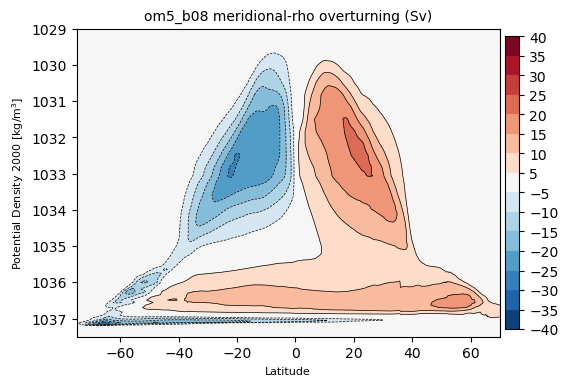

NameError: name 'dora_id' is not defined

In [18]:
# meridional-rho overturning

# for southern ocean moc
levels = [-30, -26, -22, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30]
clevels = [-30, -26, -22, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30]

# for global moc
levels = [-40, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 40]
clevels = [-40, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 40]


fig, axis = plt.subplots(1, 1, figsize=(6.5, 4))
field = psi
ycoord = psi["rho2_l"]
xcoord = static["yq"]
xcoordmesh, ycoordmesh = np.meshgrid(xcoord, ycoord)

p = plt.contourf(
    xcoord,
    ycoord,
    field,
    cmap="RdBu_r",
    levels=levels,
    linewidths=0.25,
)
plt.contour(xcoordmesh, ycoordmesh, field, clevels, colors="k", linewidths=0.5)
# plt.xlim((-75,-30))
plt.xlim((-75, 70))
plt.ylim((1029, 1037.5))
plt.gca().invert_yaxis()

axis.set_ylabel("Potential Density 2000 [kg/m$^3$]", fontsize=8)
axis.set_xlabel("Latitude", fontsize=8)
axis.set_facecolor("gray")
axis.set_title(f"{expName} meridional-rho overturning (Sv)", fontsize=10)
cbar = plt.colorbar(
    p, pad=0.01, spacing="uniform", extend="both", shrink=0.95, orientation="vertical"
)
cbar.set_ticks(clevels)

plt.show()
fig.savefig(f"{expName}_moc_rho.png", bbox_inches="tight", dpi=300)

/vftmp/John.Krasting/pid176142/ipykernel_228084/3364835052.py:17: UserWarning: linewidths is ignored by contourf
  p = plt.contourf(


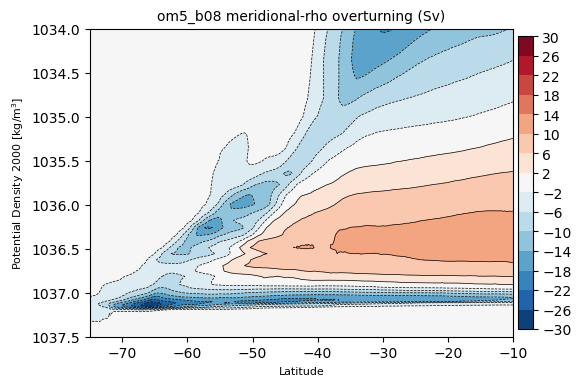

In [20]:
# meridional-rho overturning

# for global moc
levels = [-40, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 40]
clevels = [-40, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 40]

# for southern ocean moc
levels = [-30, -26, -22, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30]
clevels = [-30, -26, -22, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30]

fig, axis = plt.subplots(1, 1, figsize=(6.5, 4))
field = psi
ycoord = psi["rho2_l"]
xcoord = static["yq"]
xcoordmesh, ycoordmesh = np.meshgrid(xcoord, ycoord)

p = plt.contourf(
    xcoord,
    ycoord,
    field,
    cmap="RdBu_r",
    levels=levels,
    linewidths=0.5,
)
plt.contour(xcoordmesh, ycoordmesh, field, clevels, colors="k", linewidths=0.5)
plt.xlim((-75, -10))
# plt.ylim((1030,1037.5))
plt.ylim((1034, 1037.5))
plt.gca().invert_yaxis()

axis.set_ylabel("Potential Density 2000 [kg/m$^3$]", fontsize=8)
axis.set_xlabel("Latitude", fontsize=8)
axis.set_facecolor("gray")
axis.set_title(f"{expName} meridional-rho overturning (Sv)", fontsize=10)
cbar = plt.colorbar(
    p, pad=0.01, spacing="uniform", extend="both", shrink=0.95, orientation="vertical"
)
cbar.set_ticks(clevels)

plt.show()
fig.savefig(f"{expName}_somoc_rho.png", bbox_inches="tight", dpi=300)

/nbhome/John.Krasting/envs/py311/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:2162: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)


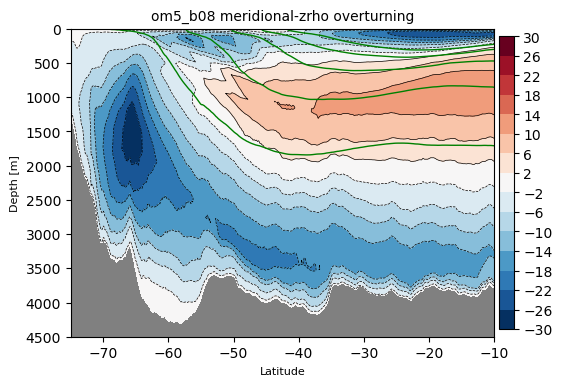

In [21]:
# meridional-rho overturning on zrho

# for global moc
levels = [-40, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 40]
clevels = [-40, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 40]

# for southern ocean moc
levels = [-30, -26, -22, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30]
clevels = levels
sigmalev = [35, 35.5, 36, 36.5, 37]

fig, axis = plt.subplots(1, 1, figsize=(6.5, 4))
field = psi

p = xr.plot.contourf(
    field,
    ax=axis,
    x="yq",
    y="depth",
    cmap="RdBu_r",
    levels=levels,
    linewidths=0.25,
    add_colorbar=False,
)

pc = xr.plot.contour(
    field,
    ax=axis,
    x="yq",
    y="depth",
    yincrease=False,
    linewidths=0.5,
    levels=clevels,
    colors="k",
)

field2 = sigmaz_xave
pcc = xr.plot.contour(
    field2,
    ax=axis,
    x="yh",
    y="z_l",
    linewidths=1,
    colors="g",
    levels=sigmalev,
    yincrease=False,
)

cbar = plt.colorbar(
    p, pad=0.01, spacing="uniform", extend="both", shrink=0.95, orientation="vertical"
)
cbar.set_ticks(levels)

plt.xlim((-75, -10))
plt.ylim((0, 4500))
plt.gca().invert_yaxis()

axis.set_ylabel("Depth [m]", fontsize=8)
axis.set_xlabel("Latitude", fontsize=8)
axis.set_facecolor("gray")
axis.set_title(f"{expName} meridional-zrho overturning", fontsize=10)

plt.show()
fig.savefig(f"{expName}_somoc_zrho.png", bbox_inches="tight", dpi=300)

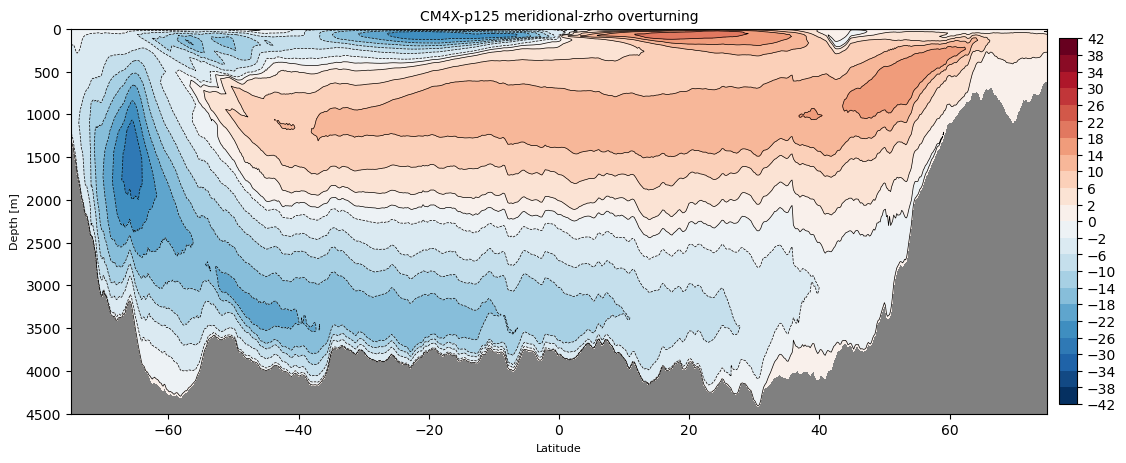

In [22]:
# meridional-rho overturning on zrho

# for southern ocean moc
levels = [-30, -26, -22, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30]
clevels = [35, 35.25, 35.5, 35.75, 36, 36.25, 36.5, 36.75, 37, 37.25]
clevels = [35, 35.5, 36, 36.5, 37]

# for global moc
levels = [
    -42,
    -38,
    -34,
    -30,
    -26,
    -22,
    -18,
    -14,
    -10,
    -6,
    -2,
    0,
    2,
    6,
    10,
    14,
    18,
    22,
    26,
    30,
    34,
    38,
    42,
]
clevels = levels


fig, axis = plt.subplots(1, 1, figsize=(15, 5))
field = psi

p = xr.plot.contourf(
    field,
    ax=axis,
    x="yq",
    y="depth",
    cmap="RdBu_r",
    levels=levels,
    linewidths=0.25,
    add_colorbar=False,
)

cbar = plt.colorbar(
    p, pad=0.01, spacing="uniform", extend="both", shrink=0.95, orientation="vertical"
)
cbar.set_ticks(levels)

pc = xr.plot.contour(
    field,
    ax=axis,
    x="yq",
    y="depth",
    yincrease=False,
    linewidths=0.5,
    levels=levels,
    colors="k",
)

# field2 = sigmaz_xave
# pcc=xr.plot.contour(field2, ax=axis, x="yh", y="z_l",
#                 linewidths=1,
#                 colors='g',
#                 levels=sigmalev,
#                 yincrease=False)


plt.xlim((-75, 75))
plt.ylim((0, 4500))
plt.gca().invert_yaxis()

axis.set_ylabel("Depth [m]", fontsize=8)
axis.set_xlabel("Latitude", fontsize=8)
axis.set_facecolor("gray")
axis.set_title("CM4X-p125 meridional-zrho overturning", fontsize=10)
# axis.text(.78,.01, 'For years 1981-2010',fontsize=8, transform=axis.transAxes)

plt.show()
fig.savefig(f"{expName}_moc_zrho.png", bbox_inches="tight", dpi=300)